<a href="https://colab.research.google.com/github/Nikunjbansal99/NLP_Lab/blob/main/NLP_LAB6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Some basic Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import re
import gensim   
import math
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
from imageio import imread
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Importing Data**

In [ ]:
train_data = R'Corona_NLP_train.csv'
train_df = pd.read_csv(train_data,encoding='latin1')

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test_data = R'Corona_NLP_test.csv'
test_df = pd.read_csv(test_data,encoding='latin1')

In [ ]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
full_df = pd.concat([train_df, test_df], sort=False)      # Concatenate train_df & test_df

**We only created full_df to make pre-processing easier. As you know, we need to train the model for training data only and perform prediction on Testing Data only. So we need to initialize some Variable(i.e. n_train) to differentiate b/w Training and Testing Data.**

In [ ]:
ntrain = train_df.shape[0]

In [ ]:
ntrain                                # To identify the tuples that belongs to training data in full_df

41157

# **Descriptive Analysis of the dataset**

In [ ]:
print("Size of train dataset       : {}".format(train_df.shape))
print("Size of test dataset       : {}".format(test_df.shape))
print("Size of full dataset       : {}".format(full_df.shape))

Size of train dataset       : (41157, 6)
Size of test dataset       : (3798, 6)
Size of full dataset       : (44955, 6)


## **Data Description**

### **Full Data**

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [ ]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserName,44955.0,22478.0,12977.535012,1.0,11239.5,22478.0,33716.5,44955.0
ScreenName,44955.0,67430.0,12977.535012,44953.0,56191.5,67430.0,78668.5,89907.0


## **Pre-Processing**

**As you are clearly seeing that there are two features(i.e. UserName and ScreenName) whose count of unique values(i.e. 44955) is equals to number of tuples in full_df. So our conclusion is that they are not helping in prediction of target feature. they are just going to play a role like unique id's for rows. So we are going to drop these 2 features from full_df.**

In [ ]:
full_df = full_df.drop(['UserName','ScreenName'], axis=1)

In [ ]:
full_df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### **NULL VALUES**

**Now we are going to check for null values in full_df:**

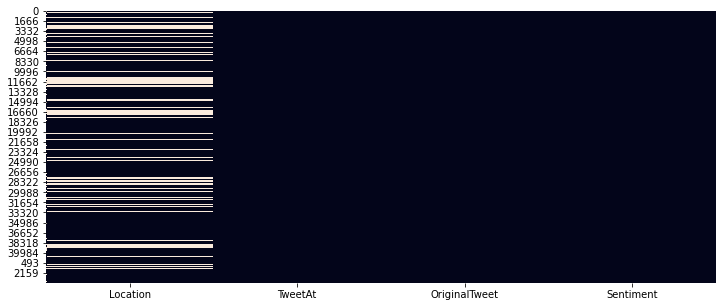

In [ ]:
plt.figure(figsize=(12, 5))
sns.heatmap(full_df.isnull(), cbar=False)        #plotting heatmap using sns library to find missing values in full_df
plt.show()

**Now, we found that 'Location' Feature Contains lots of Missing Values.**<br>
**Let's Find out how much missing values it Contains.** 

In [ ]:
full_df.isna().sum()                        # Printing a count of missing value w.r.t each feature.

Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

**Now as we are seeing in our full_df dataframe only Location feature Contains lots of Missing Values and also there is unwanted symbols at some places as values. So we are going to drop the Location Feature.**

In [ ]:
full_df = full_df.drop(['Location'], axis=1)

**We are also going to remove date stamp from full_df.**

In [ ]:
full_df = full_df.drop(['TweetAt'], axis=1)

**Assigning Label's for different Sentiment:**

In [ ]:
sent_labels_dict = {'Extremely Negative': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3, 'Extremely Positive': 4}

In [ ]:
full_df['Sentiment'] = full_df['Sentiment'].map(sent_labels_dict)
full_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,3
2,Coronavirus Australia: Woolworths to give elde...,3
3,My food stock is not the only one which is emp...,3
4,"Me, ready to go at supermarket during the #COV...",0


In [ ]:
Preprocessed_train_df = full_df[:ntrain]
Preprocessed_test_df = full_df[ntrain:]

In [ ]:
# adding a column to represent the length of the tweet

Preprocessed_train_df['length'] = Preprocessed_train_df['OriginalTweet'].str.len()
Preprocessed_test_df['length'] = Preprocessed_test_df['OriginalTweet'].str.len()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# **Analysis of Target Variable**

**{'Extremely Negative': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3, 'Extremely Positive': 4}**

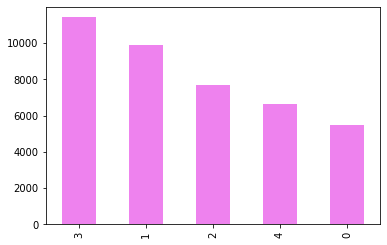

In [ ]:
Preprocessed_train_df['Sentiment'].value_counts().plot.bar(color = 'violet', figsize = (6, 4))

In [ ]:
Preprocessed_train_df.groupby('Sentiment').describe()

length                                                         
             count        mean        std   min    25%    50%    75%    max
Sentiment                                                                  
0           5481.0  221.479839  59.985132  14.0  181.0  237.0  271.0  355.0
1           9917.0  203.334174  67.117114  18.0  151.0  212.0  257.0  331.0
2           7713.0  168.160897  72.648841  11.0  109.0  160.0  229.0  325.0
3          11422.0  207.056558  66.651587  11.0  156.0  218.0  259.0  350.0
4           6624.0  228.237470  58.390527  19.0  192.0  241.0  275.0  338.0

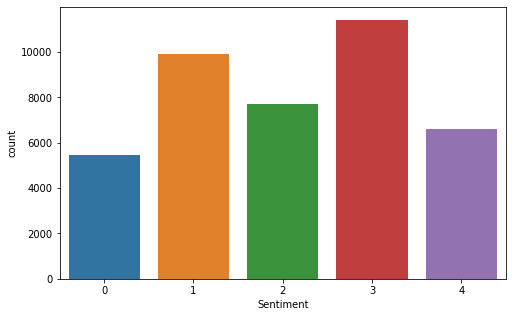

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Sentiment', data=Preprocessed_train_df, order=[0, 1, 2, 3, 4] )

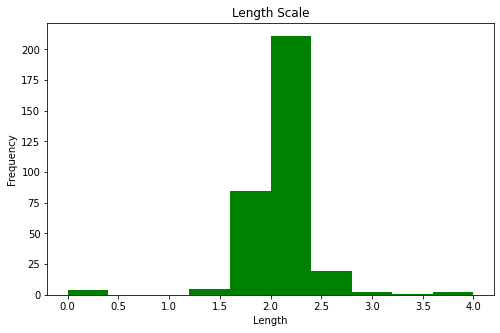

In [ ]:
Preprocessed_train_df.groupby('length').mean()['Sentiment'].plot.hist(color = 'green', figsize = (8, 5))
plt.title('Length Scale')
plt.xlabel('Length')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

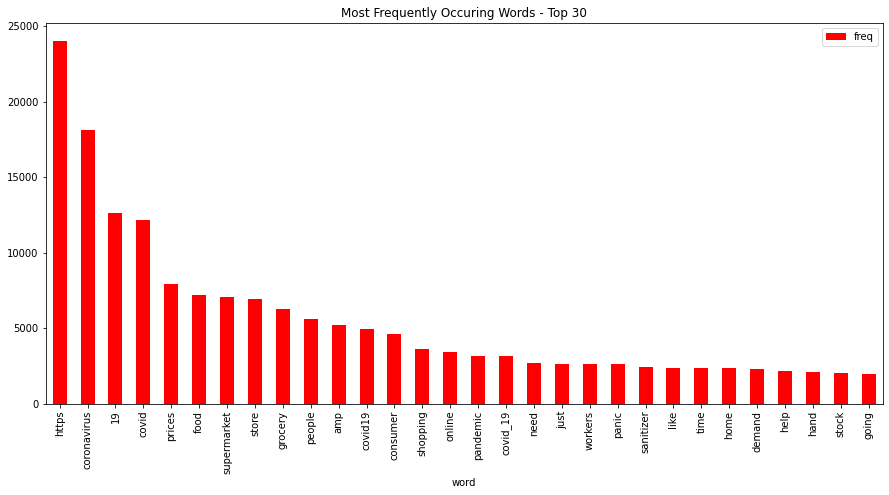

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
w = cv.fit_transform(Preprocessed_train_df.OriginalTweet)

sum_w = w.sum(axis=0)

words_freq = [(word, sum_w[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'red')
plt.title("Most Frequently Occuring Words - Top 30")

# **Word Cloud For Vocabulary:**

In [ ]:
twitter_mask = imread('./twitter_mask.png')

Text(0.5, 1.0, 'WordCloud - Vocabulary')

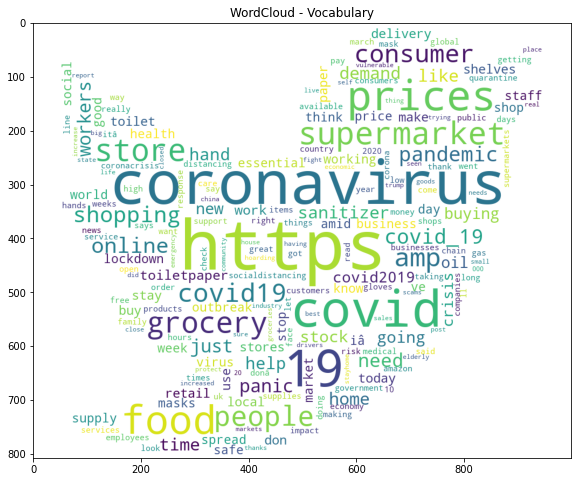

In [ ]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000, mask=twitter_mask).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary", fontsize = 12)

In [ ]:
# Creating Funtion for Extracting Hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [ ]:
# Extracting hashtags from Extremely Negative tweets:
HT_ExtNegative = hashtag_extract(Preprocessed_train_df['OriginalTweet'][Preprocessed_train_df['Sentiment'] == 0])

# Extracting hashtags from Negative tweets:
HT_Negative = hashtag_extract(Preprocessed_train_df['OriginalTweet'][Preprocessed_train_df['Sentiment'] == 1])

# Extracting hashtags from Neutral tweets:
HT_Neutral = hashtag_extract(Preprocessed_train_df['OriginalTweet'][Preprocessed_train_df['Sentiment'] == 2])

# Extracting hashtags from Positive tweets:
HT_Positive = hashtag_extract(Preprocessed_train_df['OriginalTweet'][Preprocessed_train_df['Sentiment'] == 3])

# Extracting hashtags from Extremely Positive tweets:
HT_ExtPositive = hashtag_extract(Preprocessed_train_df['OriginalTweet'][Preprocessed_train_df['Sentiment'] == 4])

HT_ExtNegative = sum(HT_ExtNegative,[])
HT_Negative = sum(HT_Negative,[])
HT_Neutral = sum(HT_Neutral,[])
HT_Positive = sum(HT_Positive,[])
HT_ExtPositive = sum(HT_ExtPositive,[])

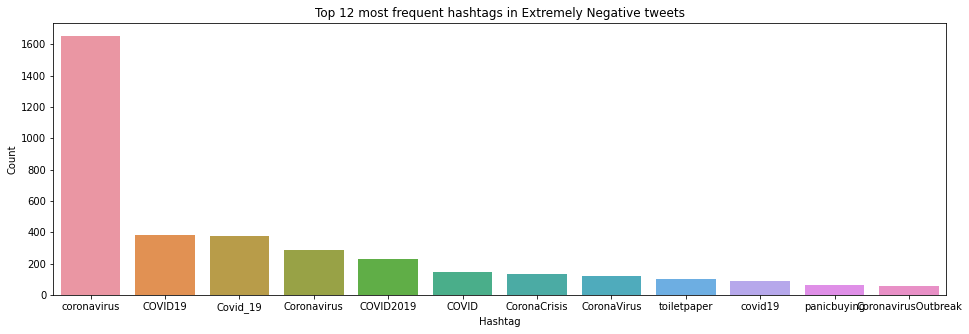

In [ ]:
G = nltk.FreqDist(HT_ExtNegative)
DF = pd.DataFrame({'Hashtag': list(G.keys()),
                  'Count': list(G.values())})  
DF = DF.nlargest(columns="Count", n = 12) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=DF, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Top 12 most frequent hashtags in Extremely Negative tweets')
plt.show()

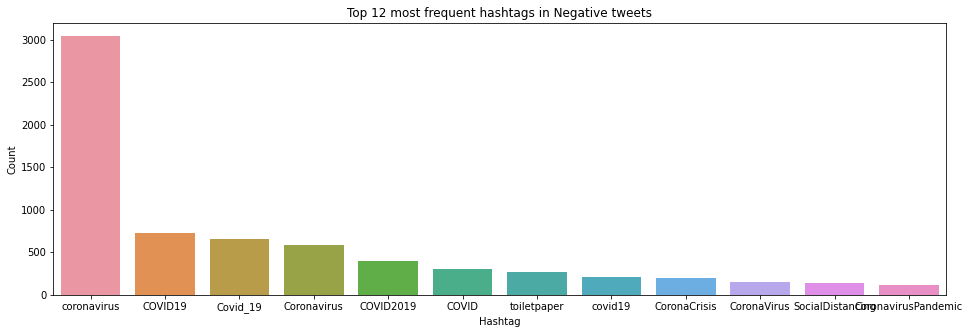

In [ ]:
G = nltk.FreqDist(HT_Negative)
DF = pd.DataFrame({'Hashtag': list(G.keys()),
                  'Count': list(G.values())})  
DF = DF.nlargest(columns="Count", n = 12) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=DF, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Top 12 most frequent hashtags in Negative tweets')
plt.show()

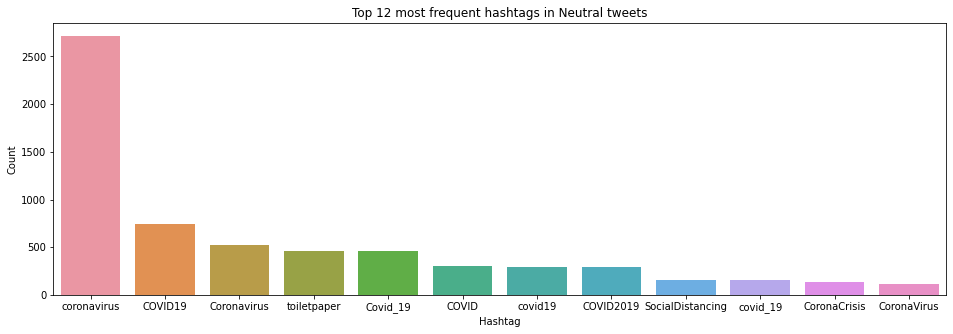

In [ ]:
G = nltk.FreqDist(HT_Neutral)
DF = pd.DataFrame({'Hashtag': list(G.keys()),
                  'Count': list(G.values())})  
DF = DF.nlargest(columns="Count", n = 12) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=DF, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Top 12 most frequent hashtags in Neutral tweets')
plt.show()

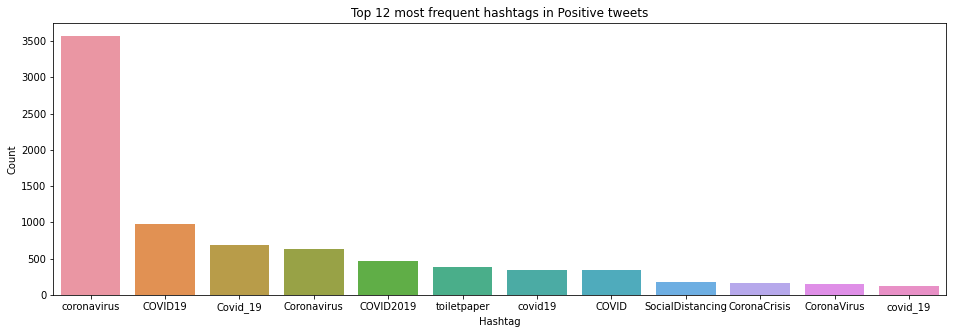

In [ ]:
G = nltk.FreqDist(HT_Positive)
DF = pd.DataFrame({'Hashtag': list(G.keys()),
                  'Count': list(G.values())})  
DF = DF.nlargest(columns="Count", n = 12) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=DF, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Top 12 most frequent hashtags in Positive tweets')
plt.show()

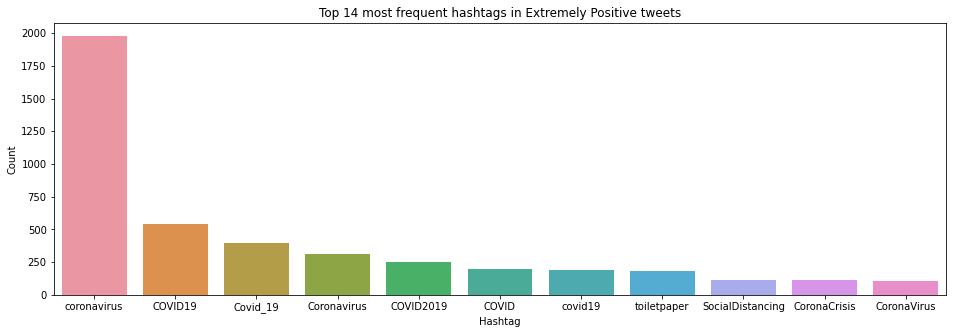

In [ ]:
G = nltk.FreqDist(HT_ExtPositive)
DF = pd.DataFrame({'Hashtag': list(G.keys()),
                  'Count': list(G.values())})  
DF = DF.nlargest(columns="Count", n = 11) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=DF, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title('Top 14 most frequent hashtags in Extremely Positive tweets')
plt.show()

In [ ]:
label_sent_dict = {0 : 'Extremely Negative',1 : 'Negative',  2 :'Neutral', 3: 'Positive',  4:'Extremely Positive'}

In [ ]:
Preprocessed_train_df['Sentiment'] = Preprocessed_train_df['Sentiment'].map(label_sent_dict)
Preprocessed_test_df['Sentiment'] = Preprocessed_test_df['Sentiment'].map(label_sent_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Preprocessed_train_df = Preprocessed_train_df.drop(['length'], axis=1)
Preprocessed_test_df = Preprocessed_test_df.drop(['length'], axis=1)

# **Removing unwanted Symbols from the OriginalTweet:**

In [ ]:
RegularExpOp = re.compile("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)")

In [ ]:
train_t = []
test_t = []

In [ ]:
for i in Preprocessed_train_df["OriginalTweet"]:
  train_t.append(RegularExpOp.sub(" ", i))

Preprocessed_train_df["OriginalTweet"] = pd.DataFrame(train_t, columns=["OriginalTweet"])

In [ ]:
for i in Preprocessed_test_df["OriginalTweet"]:
  test_t.append(RegularExpOp.sub(" ", i))

Preprocessed_test_df["OriginalTweet"] = pd.DataFrame(test_t, columns=["OriginalTweet"])

# **Doing Tokenization:**

In [ ]:
tokens = Preprocessed_train_df['OriginalTweet'].apply(lambda x: x.split())                  # generate tokens from OriginalTweet

# **Creating Model for Word to Vector:**

In [ ]:
Word2VectorModel = gensim.models.Word2Vec(tokens,size=200, window=5, min_count=2,sg = 1, hs = 0,negative = 10, workers= 2, seed = 34)

In [ ]:
Word2VectorModel.train(tokens, total_examples= len(Preprocessed_train_df['OriginalTweet']), epochs=20)

(18394718, 23248740)

In [ ]:
Word2VectorModel.wv.most_similar(positive = "coronavirus")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Coronavirus', 0.5375526547431946),
 ('intensifies', 0.502723753452301),
 ('insiders', 0.5024876594543457),
 ('BiziTalk', 0.49853479862213135),
 ('samreen', 0.48177215456962585),
 ('Plea', 0.47877973318099976),
 ('sounded', 0.4742811322212219),
 ('9to5Mac', 0.47368180751800537),
 ('CTV', 0.47348111867904663),
 ('Superstores', 0.4728062152862549)]

In [ ]:
Word2VectorModel.wv.most_similar(negative = "CoronaCrisis")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Contact', -0.04635681211948395),
 ('Service', -0.059571728110313416),
 ('animal', -0.08397555351257324),
 ('Act', -0.08525799214839935),
 ('tools', -0.08911516517400742),
 ('Care', -0.0918942242860794),
 ('Community', -0.09859509021043777),
 ('Workers', -0.09959042072296143),
 ('systems', -0.10514864325523376),
 ('Control', -0.10630212724208832)]

In [ ]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokens)                                                 # label all the tweets
labeled_tweets[1:8]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


[LabeledSentence(words=['advice', 'Talk', 'to', 'your', 'neighbours', 'family', 'to', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'of', 'neighbours', 'schools', 'employer', 'chemist', 'GP', 'set', 'up', 'online', 'shopping', 'accounts', 'if', 'poss', 'adequate', 'supplies', 'of', 'regular', 'meds', 'but', 'not', 'over', 'order'], tags=['tweet_1']),
 LabeledSentence(words=['Coronavirus', 'Australia', 'Woolworths', 'to', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'COVID', '19', 'outbreak'], tags=['tweet_2']),
 LabeledSentence(words=['My', 'food', 'stock', 'is', 'not', 'the', 'only', 'one', 'which', 'is', 'empty', 'PLEASE', 'don', 't', 'panic', 'THERE', 'WILL', 'BE', 'ENOUGH', 'FOOD', 'FOR', 'EVERYONE', 'if', 'you', 'do', 'not', 'take', 'more', 'than', 'you', 'need', 'Stay', 'calm', 'stay', 'safe', '19'], tags=['tweet_3']),
 LabeledSentence(words=['Me', 'ready', 'to', 'go', 'at', 'supermarket', 'during', 'the', 'ou

# **Creating Bag of Words:**

In [ ]:
stop_words = set(stopwords.words('english'))  
vectoriser = TfidfVectorizer(stop_words=None)  

In [ ]:
le = LabelEncoder()
trainy = le.fit_transform(Preprocessed_train_df['Sentiment'])
testy = le.transform(Preprocessed_test_df['Sentiment'])

In [ ]:
trainX = vectoriser.fit_transform(Preprocessed_train_df["OriginalTweet"])
testX = vectoriser.transform(Preprocessed_test_df["OriginalTweet"])

In [ ]:
print("Shape of trainX:",trainX.shape)
print("Shape of trainy:",trainy.shape)

Shape of trainX: (41157, 34859)
Shape of trainy: (41157,)


In [ ]:
print("Shape of testX:",testX.shape)
print("Shape of testy:",testy.shape)

Shape of testX: (3798, 34859)
Shape of testy: (3798,)


# **Creating Naive Bayes Model:**

In [ ]:
#Create a Gaussian Classifier
NBModel = MultinomialNB()
# Train the model using the training sets
NBModel.fit(trainX, trainy)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predy = NBModel.predict(testX)

In [ ]:
print("Training Score :", NBModel.score(trainX, trainy))
print("Testing Score :", NBModel.score(testX, testy))

Training Score : 0.5068639599582088
Testing Score : 0.35150078988941547


In [ ]:
ns_probs = [0 for _ in range(len(testy))]
naivebayes_probs = NBModel.predict_proba(testX)

naivebayes_probs = naivebayes_probs[:, 1]

print("Naive Bayes Probabilities:") 
print(naivebayes_probs)

Naive Bayes Probabilities:
[0.07934264 0.11805751 0.37842062 ... 0.05128415 0.07856496 0.26405968]


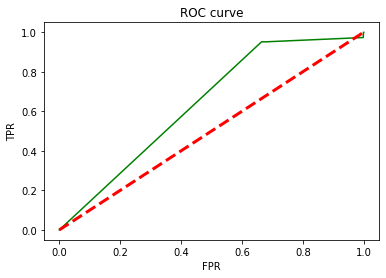

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(testy, predy, pos_label=1)

t = np.linspace(0,2*math.pi,400)
A = plt.plot(fpr, tpr, color='green')
B = plt.plot((0,1),(0,1),color='red',linewidth=3,linestyle='--') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [ ]:
# area under the curve
print("AUC of the predictions: {0}".format(metrics.auc(fpr, tpr)))

AUC of the predictions: 0.6389011382417605


**On Training Data:**

In [ ]:
train_predy = NBModel.predict(trainX)

In [ ]:
print("NB_Confusion Matrix:")
print(confusion_matrix(trainy,train_predy))

print("NB_Classification Report")
print(classification_report(trainy, train_predy))

NB_Confusion Matrix:
[[  430     0  3582    18  1451]
 [    0   827   167     4  5626]
 [    5     1  6636    16  3259]
 [    2     4  1041  1993  4673]
 [    1    12   420    14 10975]]
NB_Classification Report
              precision    recall  f1-score   support

           0       0.98      0.08      0.15      5481
           1       0.98      0.12      0.22      6624
           2       0.56      0.67      0.61      9917
           3       0.97      0.26      0.41      7713
           4       0.42      0.96      0.59     11422

    accuracy                           0.51     41157
   macro avg       0.78      0.42      0.39     41157
weighted avg       0.72      0.51      0.44     41157



**On Testing Data:**

In [ ]:
print("NB_Confusion Matrix:")
print(confusion_matrix(testy, predy))

print("NB_Classification Report")
print(classification_report(testy, predy))

NB_Confusion Matrix:
[[  1   0 414   1 176]
 [  0  16  13   0 570]
 [  1   0 418   3 619]
 [  0   1 109  39 470]
 [  0   1  81   4 861]]
NB_Classification Report
              precision    recall  f1-score   support

           0       0.50      0.00      0.00       592
           1       0.89      0.03      0.05       599
           2       0.40      0.40      0.40      1041
           3       0.83      0.06      0.12       619
           4       0.32      0.91      0.47       947

    accuracy                           0.35      3798
   macro avg       0.59      0.28      0.21      3798
weighted avg       0.54      0.35      0.26      3798





## **Predictions on Test Data:**

In [ ]:
outputdataFrame= pd.DataFrame({'Actual Sentiment': testy, 'Predicted Sentiment ': predy})

In [ ]:
#Save to csv
outputdataFrame.to_csv('NB_pred.csv',index=False)
outputdataFrame.head()

,Actual Sentiment,Predicted Sentiment
0,0,2
1,4,4
2,1,4
3,2,2
4,3,2


Colab Link For same Notebook:
https://colab.research.google.com/drive/1sQu3O4uI-J4fyZSFVzmO1f81rJSrX0oe?usp=sharing

**Thank you**,<br>
Nikunj Bansal,<br>
R177218063,<br>
B2 Batch<br>